In [1]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/g300046/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/g300046/levante-spawner-preset//proxy/8787/status,Workers: 16
Total threads: 256,Total memory: 235.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33965,Workers: 16
Dashboard: /user/g300046/levante-spawner-preset//proxy/8787/status,Total threads: 256
Started: Just now,Total memory: 235.37 GiB
Comm: tcp://127.0.0.1:33409,Total threads: 16
Dashboard: /user/g300046/levante-spawner-preset//proxy/34379/status,Memory: 14.71 GiB
Nanny: tcp://127.0.0.1:38273,


In [4]:
from pyresample.geometry import AreaDefinition
from pyresample import image, geometry
from pyresample.bucket import BucketResampler
import cordex as cx
from pyproj import CRS
import xarray as xr
import numpy as np

area_id = "glcc_igh"
description = "GLCC global"
proj_id = "glcc_igh"
# projection = {'proj': 'laea', 'lat_0': -90, 'lon_0': 0, 'a': 6371228.0, 'units': 'm'}
projection = "+proj=igh +lon_0=0 +x_0=0 +y_0=0 +ellps=sphere +units=m +no_defs=True"
width = 40031
height = 17347
area_extent = (-20015000.0, -8673000.0, 20015000.0, 8673000.0)
glcc_igh = AreaDefinition(
    area_id, description, proj_id, projection, width, height, area_extent
)


def get_cordex_area(domain_id):
    ds = cx.cordex_domain(domain_id)
    area_id = domain_id
    description = domain_id
    proj_id = domain_id
    try:
        projection = CRS.from_cf(ds.cf["grid_mapping"].attrs)  # .to_proj4()
    except:
        projection = CRS("EPSG:4326")
    # projection = {'proj': 'laea', 'lat_0': -90, 'lon_0': 0, 'a': 6371228.0, 'units': 'm'}
    width = ds.cf["X"].size
    height = ds.cf["Y"].size
    area_extent = (
        ds.cf["X"][0].item(),
        ds.cf["Y"][0].item(),
        ds.cf["X"][-1].item(),
        ds.cf["Y"][-1].item(),
    )
    return AreaDefinition(
        area_id, description, proj_id, projection, width, height, area_extent
    )

In [5]:
glcc = xr.open_dataset(
    "/work/ch0636/g300046/glcc/glccgbg20_tif/gbogeg20.nc", chunks={"x": 4010, "y": 1738}
)
glcc

<xarray.Dataset>
Dimensions:         (y: 17347, x: 40031, index: 98, bounds: 2, vertices: 4)
Coordinates:
  * x               (x) float64 -2.002e+07 -2.001e+07 ... 2.001e+07 2.002e+07
  * y               (y) float64 -8.673e+06 -8.672e+06 ... 8.672e+06 8.673e+06
  * index           (index) int64 0 1 2 3 4 5 6 7 8 ... 90 91 92 93 94 95 96 100
    classification  (index) object dask.array<chunksize=(98,), meta=np.ndarray>
    lon             (y, x) float64 dask.array<chunksize=(1738, 4010), meta=np.ndarray>
    lat             (y, x) float64 dask.array<chunksize=(1738, 4010), meta=np.ndarray>
    y_bounds        (y, bounds) float64 dask.array<chunksize=(1738, 2), meta=np.ndarray>
    x_bounds        (x, bounds) float64 dask.array<chunksize=(4010, 2), meta=np.ndarray>
    lon_bounds      (y, x, vertices) float64 dask.array<chunksize=(1738, 4010, 4), meta=np.ndarray>
    lat_bounds      (y, x, vertices) float64 dask.array<chunksize=(1738, 4010, 4), meta=np.ndarray>
Dimensions without coordinates: bounds, vertices
Data variables:
    glcc            (y, x) uint8 dask.array<chunksize=(1738, 4010), meta=np.ndarray>
Attributes:
    description:  Global Land Cover Characteristics Data Base Version 2.0.
    proj4:        +proj=igh +lon_0=0 +x_0=0 +y_0=0 +ellps=sphere +units=m +no...

In [8]:
lons = glcc.lon.data
lats = glcc.lat.data

target_area = get_cordex_area("EUR-11i")

In [9]:
resampler = BucketResampler(target_area, lons, lats)

/work/ch0636/g300046/conda_envs/pangeo/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [32]:
urban = [1]
forest = [3, 4, 5, 6]
# forest = list({k: v for k, v in type_dict.items() if "Forest" in v}.keys())
water = [14, 15]
grassland = [7, 8, 9, 10]

classes = urban + water + grassland + forest
classes

[1, 14, 15, 7, 8, 9, 10, 3, 4, 5, 6]

In [35]:
data = xr.where(glcc.glcc.isin(classes), glcc.glcc, 0).data
data

dask.array<where, shape=(17347, 40031), dtype=uint8, chunksize=(1738, 4010), chunktype=numpy.ndarray>

In [37]:
fractions = resampler.get_fractions(data, categories=classes)
fractions

{1: dask.array<where, shape=(408, 881), dtype=float64, chunksize=(408, 881), chunktype=numpy.ndarray>,
 14: dask.array<where, shape=(408, 881), dtype=float64, chunksize=(408, 881), chunktype=numpy.ndarray>,
 15: dask.array<where, shape=(408, 881), dtype=float64, chunksize=(408, 881), chunktype=numpy.ndarray>,
 7: dask.array<where, shape=(408, 881), dtype=float64, chunksize=(408, 881), chunktype=numpy.ndarray>,
 8: dask.array<where, shape=(408, 881), dtype=float64, chunksize=(408, 881), chunktype=numpy.ndarray>,
 9: dask.array<where, shape=(408, 881), dtype=float64, chunksize=(408, 881), chunktype=numpy.ndarray>,
 10: dask.array<where, shape=(408, 881), dtype=float64, chunksize=(408, 881), chunktype=numpy.ndarray>,
 3: dask.array<where, shape=(408, 881), dtype=float64, chunksize=(408, 881), chunktype=numpy.ndarray>,
 4: dask.array<where, shape=(408, 881), dtype=float64, chunksize=(408, 881), chunktype=numpy.ndarray>,
 5: dask.array<where, shape=(408, 881), dtype=float64, chunksize=(408,

In [53]:
classes = glcc.classification.load()

In [61]:
data_vars = {
    classes.sel(index=i).item().replace(" ", "_"): (["lat", "lon"], fractions[i])
    for i in fractions
}
data_vars

{'URBAN': (['lat', 'lon'],
  dask.array<where, shape=(408, 881), dtype=float64, chunksize=(408, 881), chunktype=numpy.ndarray>),
 'INLAND_WATER': (['lat', 'lon'],
  dask.array<where, shape=(408, 881), dtype=float64, chunksize=(408, 881), chunktype=numpy.ndarray>),
 'SEA_WATER': (['lat', 'lon'],
  dask.array<where, shape=(408, 881), dtype=float64, chunksize=(408, 881), chunktype=numpy.ndarray>),
 'TALL_GRASSES_AND_SHRUBS': (['lat', 'lon'],
  dask.array<where, shape=(408, 881), dtype=float64, chunksize=(408, 881), chunktype=numpy.ndarray>),
 'BARE_DESERT': (['lat', 'lon'],
  dask.array<where, shape=(408, 881), dtype=float64, chunksize=(408, 881), chunktype=numpy.ndarray>),
 'UPLAND_TUNDRA': (['lat', 'lon'],
  dask.array<where, shape=(408, 881), dtype=float64, chunksize=(408, 881), chunktype=numpy.ndarray>),
 'IRRIGATED_GRASSLAND': (['lat', 'lon'],
  dask.array<where, shape=(408, 881), dtype=float64, chunksize=(408, 881), chunktype=numpy.ndarray>),
 'CONIFEROUS_FOREST': (['lat', 'lon'],
 

In [63]:
bodlib = xr.Dataset(data_vars=data_vars)
bodlib

<xarray.Dataset>
Dimensions:                      (lat: 408, lon: 881)
Dimensions without coordinates: lat, lon
Data variables:
    URBAN                        (lat, lon) float64 dask.array<chunksize=(408, 881), meta=np.ndarray>
    INLAND_WATER                 (lat, lon) float64 dask.array<chunksize=(408, 881), meta=np.ndarray>
    SEA_WATER                    (lat, lon) float64 dask.array<chunksize=(408, 881), meta=np.ndarray>
    TALL_GRASSES_AND_SHRUBS      (lat, lon) float64 dask.array<chunksize=(408, 881), meta=np.ndarray>
    BARE_DESERT                  (lat, lon) float64 dask.array<chunksize=(408, 881), meta=np.ndarray>
    UPLAND_TUNDRA                (lat, lon) float64 dask.array<chunksize=(408, 881), meta=np.ndarray>
    IRRIGATED_GRASSLAND          (lat, lon) float64 dask.array<chunksize=(408, 881), meta=np.ndarray>
    CONIFEROUS_FOREST            (lat, lon) float64 dask.array<chunksize=(408, 881), meta=np.ndarray>
    DECIDUOUS_CONIFER_FOREST     (lat, lon) float64 dask.array<chunksize=(408, 881), meta=np.ndarray>
    DECIDUOUS_BROADLEAF_FOREST   (lat, lon) float64 dask.array<chunksize=(408, 881), meta=np.ndarray>
    EVERGREEN_BROADLEAF_FORESTS  (lat, lon) float64 dask.array<chunksize=(408, 881), meta=np.ndarray>

In [64]:
%time bodlib_ = bodlib.compute()

CPU times: user 42.9 s, sys: 5.34 s, total: 48.2 s
Wall time: 2min 34s


In [65]:
bodlib_

<xarray.Dataset>
Dimensions:                      (lat: 408, lon: 881)
Dimensions without coordinates: lat, lon
Data variables:
    URBAN                        (lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    INLAND_WATER                 (lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SEA_WATER                    (lat, lon) float64 0.0 0.0 0.0 ... 1.0 1.0 1.0
    TALL_GRASSES_AND_SHRUBS      (lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    BARE_DESERT                  (lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    UPLAND_TUNDRA                (lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    IRRIGATED_GRASSLAND          (lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CONIFEROUS_FOREST            (lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    DECIDUOUS_CONIFER_FOREST     (lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    DECIDUOUS_BROADLEAF_FOREST   (lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    EVERGREEN_BROADLEAF_FORESTS  (lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

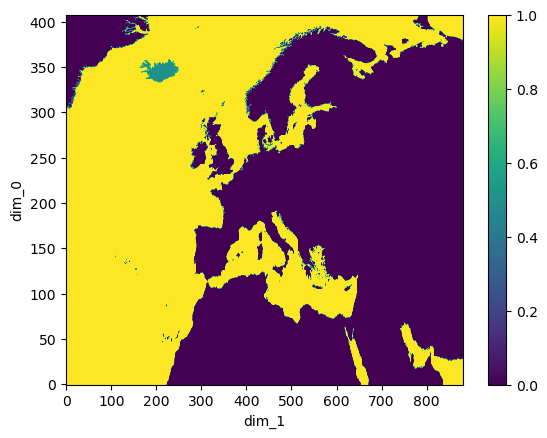

In [81]:
xr.DataArray(np.flipud(bodlib_.SEA_WATER)).plot()